In [1]:
import nqs.precissimo as pm
import nqs.utils.measurement_data as md
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# make a sampler with an RBM
sampler = pm.RBMSampler(n_visible=4, n_hidden=6, seed=42)

Created Complex RBM with 4 visible and 6 hidden units
Total parameters: 68
  (Each parameter has real and imaginary parts)


In [3]:
# Load dataset for training
sigma_s, Us = md.load_and_prepare_for_training("../Scripts/4qubit_measurements.txt", spin_notation=False)

Loaded 5000 measurements from ../Scripts/4qubit_measurements.txt
Format: binary {0,1}


In [4]:
print(sigma_s.shape)
print(len(Us))
print(Us)
print(sigma_s[0])

(5000, 4)
5000
['YYYY', 'ZZZZ', 'ZZZZ', 'IZYX', 'IZYX', 'XXII', 'IIXX', 'IZYX', 'XXII', 'IZYX', 'YYYY', 'IZYX', 'XXII', 'XXII', 'IIXX', 'YXIZ', 'IZYX', 'YXIZ', 'XXII', 'ZZZZ', 'YXIZ', 'IZYX', 'ZZZZ', 'YYYY', 'YYYY', 'IIXX', 'ZZZZ', 'XXII', 'YYYY', 'ZZZZ', 'YXIZ', 'YYYY', 'YXIZ', 'ZZZZ', 'ZZZZ', 'IIXX', 'IIXX', 'XXII', 'XXII', 'IZYX', 'IIXX', 'XXII', 'ZZZZ', 'YYYY', 'YYYY', 'YXIZ', 'XXII', 'IZYX', 'IIXX', 'XXII', 'ZZZZ', 'IIXX', 'ZZZZ', 'ZZZZ', 'IIXX', 'IIXX', 'IIXX', 'ZZZZ', 'YXIZ', 'ZZZZ', 'ZZZZ', 'YYYY', 'XXII', 'ZZZZ', 'XXII', 'YXIZ', 'YYYY', 'YXIZ', 'ZZZZ', 'IIXX', 'IIXX', 'YYYY', 'YYYY', 'ZZZZ', 'IZYX', 'ZZZZ', 'ZZZZ', 'IIXX', 'XXII', 'IIXX', 'ZZZZ', 'IIXX', 'XXII', 'YXIZ', 'IZYX', 'IIXX', 'YXIZ', 'IZYX', 'ZZZZ', 'YXIZ', 'YYYY', 'IZYX', 'YXIZ', 'YYYY', 'ZZZZ', 'IZYX', 'XXII', 'YYYY', 'IIXX', 'ZZZZ', 'XXII', 'ZZZZ', 'XXII', 'ZZZZ', 'IIXX', 'YXIZ', 'YXIZ', 'YXIZ', 'IZYX', 'IZYX', 'XXII', 'XXII', 'IZYX', 'IIXX', 'YXIZ', 'IIXX', 'IZYX', 'ZZZZ', 'YYYY', 'XXII', 'IIXX', 'ZZZZ', 'IZYX', 

In [5]:
np.unique(sigma_s)

array([0, 1])

In [6]:
# train the RBM on the measurement data

In [7]:
print("\nMeasurement bases in dataset:")
print(f"Unique bases: {set(Us[:100])}")  # Check first 100
print(f"Total unique bases: {len(set(Us))}")


Measurement bases in dataset:
Unique bases: {'ZZZZ', 'YXIZ', 'IIXX', 'IZYX', 'XXII', 'YYYY'}
Total unique bases: 6


In [20]:
from time import time

# A. implement training manually -- make this into a function later

# access mcsamples

#set learning rate
eta = 0.01
n_iterations = 1000
NLL_loss = []

# Add this before training:
print("Parameter types:")
print(f"a dtype: {sampler.a.dtype}")
print(f"b dtype: {sampler.b.dtype}")
print(f"W dtype: {sampler.W.dtype}")

start = time()
for step in range(n_iterations):
    
    # make some mc samples
    samples = sampler.sample_from_distribution(n_samples=5000,burn_in=1000,thin=5)

    # d_ai = - 1/M * np.sum(sigma_i in Dataset) + 1/nmc *np.sum(sigma_i in mc_samples)
    # grad wrt all a_i
    d_ai = -sigma_s.mean(axis=0) + samples.mean(axis=0)  
    print("shape of d_ai:", d_ai.shape)
        
    # grad wrt all b_j and all Wij
    
    theta_data = sampler.b + sigma_s @ sampler.W
    theta_mc = sampler.b + samples @ sampler.W
    
    
    d_bj =  - np.tanh(theta_data).mean(axis=0) + np.tanh(theta_mc).mean(axis=0)
    print("shape of d_bj:", d_bj.shape)
    
    #grad wrt all W_ij
    d_wij = - (sigma_s.T @ np.tanh(theta_data)) / len(sigma_s) + (samples.T @ np.tanh(theta_mc)) / len(samples)
    print("shape of d_wij:", d_wij.shape)
    
    
    # 3. iteratively make updates to the parameters of the RBM
    # lambda = lambda - eta*grad_L
    
    sampler.a = sampler.a - eta * np.conj(d_ai)
    sampler.b = sampler.b - eta * np.conj(d_bj)
    sampler.W = sampler.W - eta * np.conj(d_wij)

    # 4. append loss value to a list after this iteration
    # iteration_loss = - 1/M * np.sum(log_prob_psi_sigma in Dataset)
    
    
    if step % 10 == 0:
        
        # recompute w updated params
        theta_current = sampler.b + sigma_s @ sampler.W

        log_probs  = (sigma_s @ sampler.a) + np.sum(np.log(2 * np.cosh(theta_current)), axis=1)
        nll = -2 * np.mean(np.real(log_probs))    # same formula as in log_prob unnormalized ^^
        NLL_loss.append(nll)
        
        elapsed = time() - start
        print(f"Step {step:3d}/{n_iterations}, NLL = {nll:.4f}, Time = {elapsed:.1f}s")
        
        #DEBUG INFOR
        print(f"  Gradient norms: ||d_a||={np.linalg.norm(d_ai):.4f}, "
              f"||d_b||={np.linalg.norm(d_bj):.4f}, ||d_W||={np.linalg.norm(d_wij):.4f}")
        print(f"  log_probs range: [{np.min(log_probs):.2f}, {np.max(log_probs):.2f}]")
        print()




Parameter types:
a dtype: complex128
b dtype: complex128
W dtype: complex128

Starting MCMC sampling from |ψ_λ|²...
  Burn-in: 1000 steps
  Collecting: 5000 samples
  Thinning: every 5 steps
  Total MCMC steps: 26000
  Step 2000/26000, acceptance rate: 0.981
  Step 4000/26000, acceptance rate: 0.981
  Step 6000/26000, acceptance rate: 0.983
  Step 8000/26000, acceptance rate: 0.983
  Step 10000/26000, acceptance rate: 0.982
  Step 12000/26000, acceptance rate: 0.982
  Step 14000/26000, acceptance rate: 0.982
  Step 16000/26000, acceptance rate: 0.982
  Step 18000/26000, acceptance rate: 0.981
  Step 20000/26000, acceptance rate: 0.982
  Step 22000/26000, acceptance rate: 0.982
  Step 24000/26000, acceptance rate: 0.982
  Step 26000/26000, acceptance rate: 0.982

✓ Sampling complete!
  Final acceptance rate: 0.982
  (Optimal range: 0.2 - 0.5 for Metropolis-Hastings)
shape of d_ai: (4,)
shape of d_bj: (6,)
shape of d_wij: (4, 6)
Step   0/1000, NLL = -8.2825, Time = 0.2s
  Gradient norms:

In [9]:
# Add this diagnostic RIGHT at the start of training:
print("\n=== CRITICAL DIAGNOSTIC ===")
print(f"sigma_s: shape={sigma_s.shape}, dtype={sigma_s.dtype}")
print(f"  unique values: {np.unique(sigma_s)}")
print(f"  sample: {sigma_s[0]}")
print(f"  mean: {sigma_s.mean(axis=0)}")

# And in the first iteration:
print(f"\nsamples: shape={samples.shape}, dtype={samples.dtype}")
print(f"  unique values: {np.unique(samples)}")
print(f"  sample: {samples[0]}")
print(f"  mean: {samples.mean(axis=0)}")


=== CRITICAL DIAGNOSTIC ===
sigma_s: shape=(5000, 4), dtype=int64
  unique values: [0 1]
  sample: [0 1 1 0]
  mean: [0.5046 0.4914 0.5072 0.4818]

samples: shape=(5000, 4), dtype=int64
  unique values: [0 1]
  sample: [0 0 0 1]
  mean: [0.491  0.4948 0.505  0.4742]


In [10]:
# so the trained RBM now represents the quantum state that was used to generate that measurement dataset
sampler.log_wavefunction(sigma_s[0])

np.complex128(4.148677935228403-0.021272313087757504j)

In [11]:
sampler.sample_from_distribution(1)


Starting MCMC sampling from |ψ_λ|²...
  Burn-in: 1000 steps
  Collecting: 1 samples
  Thinning: every 10 steps
  Total MCMC steps: 1010

✓ Sampling complete!
  Final acceptance rate: 0.977
  (Optimal range: 0.2 - 0.5 for Metropolis-Hastings)


array([[1, 1, 1, 1]])

In [12]:
d_ai

array([-0.0136,  0.0034, -0.0022, -0.0076])

In [13]:
#bj and wij are complex!
d_bj

array([ 5.23636915e-04-7.86724592e-05j, -1.63909701e-05+5.34173311e-04j,
       -6.08969094e-04-1.85211122e-03j,  5.27032016e-04-2.62941375e-04j,
        1.62674901e-03-1.08971950e-03j, -4.19449957e-04-3.04895772e-04j])

In [14]:
d_wij

array([[ 0.00519547-0.0009407j , -0.00083555+0.00617979j,
        -0.00486395-0.019304j  ,  0.00558212-0.00212716j,
         0.01623591-0.01153794j, -0.00502274-0.00320872j],
       [-0.0042509 +0.00086378j,  0.00060625-0.00495678j,
         0.00445144+0.01615951j, -0.00475161+0.00179915j,
        -0.01323056+0.00979906j,  0.00392217+0.00260323j],
       [-0.00397941+0.00084688j,  0.00140356-0.00434562j,
         0.00370641+0.01439061j, -0.0041179 +0.00178062j,
        -0.01171447+0.00845026j,  0.00377577+0.00205572j],
       [ 0.00407629-0.00104049j, -0.00139508+0.00572577j,
        -0.00401227-0.01647828j,  0.00516756-0.00133617j,
         0.01313446-0.01043924j, -0.00456393-0.00263508j]])

In [15]:
sigma_s[0]

array([0, 1, 1, 0])

In [16]:
np.unique(samples)

array([0, 1])

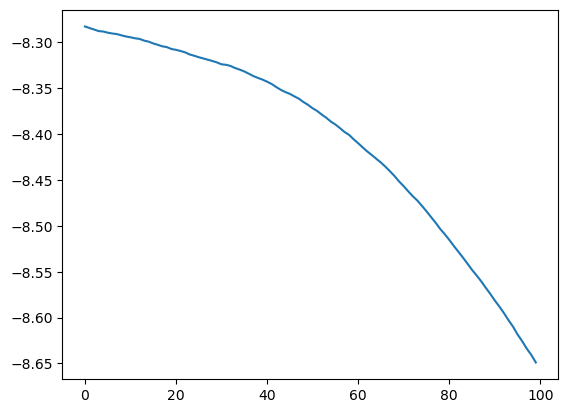

In [21]:
# B. output the loss
plt.plot(range(len(NLL_loss)), NLL_loss)


In [18]:

# COMMENTS; Looks healthy af..could do with a bit more iterations to see where it finally settles.
# or possibly implement a different learning rate schedule

## On 2nd thought that gradient computation might need some proofing because I can't
## see why we're ignoring the expectation over the quasi-probability distribution
# also not sure about the measurement dataset we generated: -- check Victor's version
# is it that we always technically measure in the Z basis but if we want to measure in 
# a different basis we just apply a rotation then measure in Z and this is effectively measuring 
# in that chosen basis right? -- so the unitary U that rotates the state so that when make the measurement
# we're actually measuring in the desired basis is not trivial right? so that means that the quasi-dist
# shouldn't be ignored?

Estimating Observable Expectation Value
Sampling 10000 configurations from trained RBM...

Starting MCMC sampling from |ψ_λ|²...
  Burn-in: 2000 steps
  Collecting: 10000 samples
  Thinning: every 10 steps
  Total MCMC steps: 102000
  Step 2000/102000, acceptance rate: 0.988
  Step 4000/102000, acceptance rate: 0.983
  Step 6000/102000, acceptance rate: 0.982
  Step 8000/102000, acceptance rate: 0.981
  Step 10000/102000, acceptance rate: 0.981
  Step 12000/102000, acceptance rate: 0.981
  Step 14000/102000, acceptance rate: 0.982
  Step 16000/102000, acceptance rate: 0.982
  Step 18000/102000, acceptance rate: 0.982
  Step 20000/102000, acceptance rate: 0.981
  Step 22000/102000, acceptance rate: 0.981
  Step 24000/102000, acceptance rate: 0.981
  Step 26000/102000, acceptance rate: 0.981
  Step 28000/102000, acceptance rate: 0.981
  Step 30000/102000, acceptance rate: 0.981
  Step 32000/102000, acceptance rate: 0.981
  Step 34000/102000, acceptance rate: 0.981
  Step 36000/102000, ac

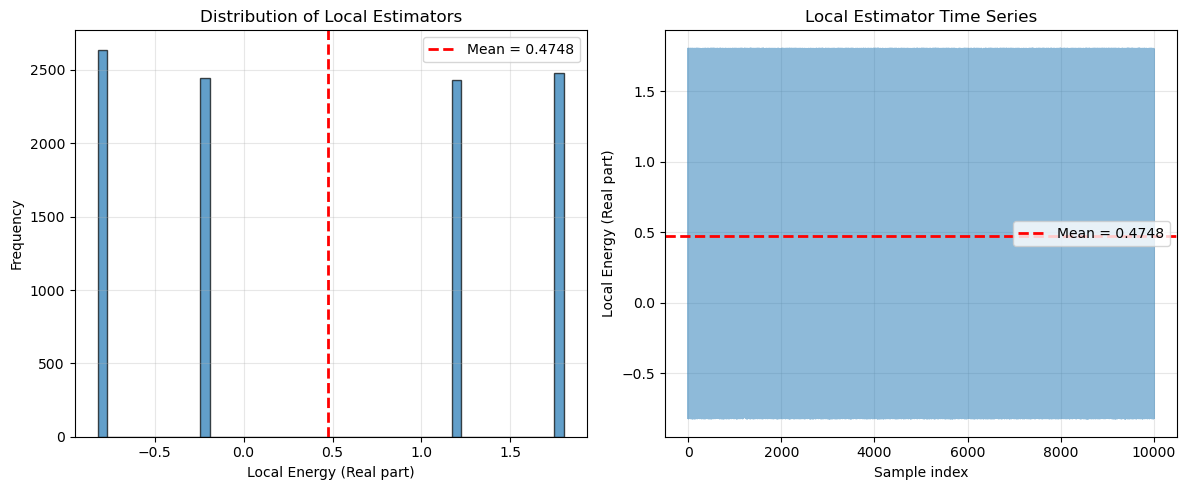


Variance of local estimator: 1.147268
(Lower variance = better state reconstruction)


In [19]:
# 4. Example Usage


# Define Hamiltonian as a sum of Pauli strings
# Example: H = 0.5*X₁X₂ + 0.3*Z₁Z₂ - 0.2*Y₁I₂I₃I₄

hamiltonian = [
    (0.5, 'XXII'),   # X on qubits 0,1
    (0.3, 'ZZII'),   # Z on qubits 0,1
    (-0.2, 'YIII'),  # Y on qubit 0
    (1.0, 'IIZI'),   # Z on qubit 2
    # Add more terms as needed
]

# Use trained RBM
# sampler is the trained RBMSampler from before

print("="*60)
print("Estimating Observable Expectation Value")
print("="*60)

# Estimate ⟨H⟩
energy, energy_error, local_energies = pm.estimate_observable(
    rbm=sampler,
    pauli_terms=hamiltonian,
    n_samples=10000,
    burn_in=2000,
    thin=10
)

print(f"\n{'='*60}")
print(f"Results:")
print(f"{'='*60}")
print(f"⟨H⟩ = {np.real(energy):.6f} ± {energy_error:.6f}")
print(f"Imaginary part: {np.imag(energy):.6e} (should be ≈0)")
print(f"{'='*60}")

# ============================================
# 5. Diagnostics and Visualization
# ============================================

import matplotlib.pyplot as plt

# Plot distribution of local energies
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(np.real(local_energies), bins=50, alpha=0.7, edgecolor='black')
plt.axvline(np.real(energy), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {np.real(energy):.4f}')
plt.xlabel('Local Energy (Real part)')
plt.ylabel('Frequency')
plt.title('Distribution of Local Estimators')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(np.real(local_energies), alpha=0.5)
plt.axhline(np.real(energy), color='red', linestyle='--', linewidth=2,
            label=f'Mean = {np.real(energy):.4f}')
plt.xlabel('Sample index')
plt.ylabel('Local Energy (Real part)')
plt.title('Local Estimator Time Series')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Variance of the estimator (should be small for good reconstruction)
variance = np.var(local_energies)
print(f"\nVariance of local estimator: {variance:.6f}")
print(f"(Lower variance = better state reconstruction)")

In [ ]:
# C. reproduce measurement outcomees -- make q, the reconstruction of the distribution - like in Victor's code

In [ ]:
# Part 2: the BeH2 case 
# - make the plots for the distribution of the estimate of the observable
# - make plot for infedility at each training step like in Juan's tutorial

# NB: When doing the example of the BeH2 molecule, calculate expcilictly the ground state
# and get plot the fidelity of the reconstructed state of the rbm at each training iteration 
# like in Juan's tutorial! should see sigmoid like shape like Alex's plot too


### Using the samples

Once $n_{\mathrm{MC}}$ samples $\{\boldsymbol{\sigma}^{(k)}\}_{k=1}^{n_{\mathrm{MC}}} \sim |\psi_\lambda|^2$ are collected, any observable can be estimated using the *local estimator*:

$$
O_\lambda = \frac{1}{n_{\mathrm{MC}}} \sum_{k=1}^{n_{\mathrm{MC}}} \frac{\langle \boldsymbol{\sigma}^{(k)}| \hat{O} |\psi_\lambda\rangle}{\langle \boldsymbol{\sigma}^{(k)}|\psi_\lambda\rangle}
$$

This estimator converges to $\langle \hat{O} \rangle$ in the limit of large $n_{\mathrm{MC}}$.

## Training an RBM to Reproduce Quantum Measurement Distributions

Assume a quantum circuit prepares an $N$-qubit state $|\psi\rangle$. Repeated measurements in some local basis (e.g. the computational $Z$ basis) produce a dataset of binary outcomes

$$
\mathcal{D} = \{\boldsymbol{\sigma}^{(1)}, \boldsymbol{\sigma}^{(2)}, \ldots, \boldsymbol{\sigma}^{(M)}\}, \qquad \boldsymbol{\sigma}^{(k)} \in \{\pm 1\}^N
$$

Each bitstring $\boldsymbol{\sigma}$ is observed with probability

$$
P_{\mathrm{data}}(\boldsymbol{\sigma}) = |\langle \boldsymbol{\sigma} | \psi \rangle|^2
$$

Our goal is to train a Restricted Boltzmann Machine (RBM) such that its marginal probability distribution $P_\lambda(\boldsymbol{\sigma})$ approximates $P_{\mathrm{data}}(\boldsymbol{\sigma})$.

### RBM model of the measurement distribution

The RBM defines a joint distribution over visible and hidden spins $\boldsymbol{\sigma}$ and $\boldsymbol{h}$:

$$
P_\lambda(\boldsymbol{\sigma}, \boldsymbol{h}) = \frac{1}{Z_\lambda} \exp\left( \sum_i a_i \sigma_i + \sum_j b_j h_j + \sum_{ij} W_{ij}\sigma_i h_j \right)
$$

with partition function

$$
Z_\lambda = \sum_{\boldsymbol{\sigma},\boldsymbol{h}} \exp[-E_\lambda(\boldsymbol{\sigma},\boldsymbol{h})]
$$

The visible-layer marginal is then

$$
P_\lambda(\boldsymbol{\sigma}) = \sum_{\boldsymbol{h}} P_\lambda(\boldsymbol{\sigma},\boldsymbol{h}) = \frac{1}{Z_\lambda} e^{\sum_i a_i \sigma_i} \prod_j 2\cosh\left(b_j + \sum_i W_{ij}\sigma_i\right)
$$

### Training objective

We minimize the Kullback-Leibler (KL) divergence between the true data distribution and the RBM model:

$$
\mathcal{C}(\lambda) = D_{\mathrm{KL}}(P_{\mathrm{data}} \| P_\lambda) = \sum_{\boldsymbol{\sigma}} P_{\mathrm{data}}(\boldsymbol{\sigma}) \ln \frac{P_{\mathrm{data}}(\boldsymbol{\sigma})}{P_\lambda(\boldsymbol{\sigma})}
$$

Because the term involving $P_{\mathrm{data}}$ is constant w.r.t. $\lambda$, minimizing $\mathcal{C}$ is equivalent to maximizing the log-likelihood of the data:

$$
\mathcal{L}(\lambda) = \sum_{\boldsymbol{\sigma}\in\mathcal{D}} \ln P_\lambda(\boldsymbol{\sigma}) = \sum_{\boldsymbol{\sigma}\in\mathcal{D}} \left[ \sum_i a_i \sigma_i + \sum_j \ln 2\cosh\left(b_j + \sum_i W_{ij}\sigma_i\right) \right] - M \ln Z_\lambda
$$

### Gradient of the log-likelihood

The derivatives of $\mathcal{L}$ with respect to the parameters are

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial a_i} &= \langle \sigma_i \rangle_{\mathrm{data}} - \langle \sigma_i \rangle_{\mathrm{model}} \\[4pt]
\frac{\partial \mathcal{L}}{\partial b_j} &= \langle \tanh(\theta_j) \rangle_{\mathrm{data}} - \langle \tanh(\theta_j) \rangle_{\mathrm{model}} \\[4pt]
\frac{\partial \mathcal{L}}{\partial W_{ij}} &= \langle \sigma_i \tanh(\theta_j) \rangle_{\mathrm{data}} - \langle \sigma_i \tanh(\theta_j) \rangle_{\mathrm{model}}
\end{align}
$$

where

$$
\theta_j = b_j + \sum_i W_{ij}\sigma_i
$$

Here $\langle \cdot \rangle_{\mathrm{data}}$ denotes averages over the training dataset $\mathcal{D}$, and $\langle \cdot \rangle_{\mathrm{model}}$ denotes averages over samples drawn from the current RBM distribution $P_\lambda(\boldsymbol{\sigma})$.

### Learning algorithm

The gradients are estimated by Monte Carlo sampling, and the parameters are updated iteratively by stochastic gradient ascent:

$$
\lambda \leftarrow \lambda + \eta \nabla_\lambda \mathcal{L}
$$

where $\eta$ is the learning rate.

In practice, the expectation $\langle \cdot \rangle_{\mathrm{model}}$ is approximated by short Markov chains (initialized at data samples) using the *Contrastive Divergence* (CD-$k$) algorithm.

### Interpretation

During training, the RBM learns to approximate the probability distribution of measurement outcomes produced by the quantum circuit. If training converges ideally, we obtain

$$
P_\lambda(\boldsymbol{\sigma}) \approx |\langle \boldsymbol{\sigma} | \psi \rangle|^2
$$

meaning that the RBM effectively encodes the measurement statistics of the quantum state in its parameters. Once trained, the model can:
- Generate new synthetic measurement outcomes,
- Provide a compact probabilistic representation of the quantum state,
- Serve as the basis for reconstructing expectation values of observables using Monte Carlo estimators.

## Uncertainty of an Observable Written as a Sum of Pauli Words

Let the quantum observable $\hat{O}$ be expressed as a linear combination of tensor products of Pauli operators ("Pauli words"):

$$
\hat{O} = \sum_{k=1}^{K} c_k \hat{P}_k, \qquad \hat{P}_k \in \{ \hat{I}, \hat{\sigma}_x, \hat{\sigma}_y, \hat{\sigma}_z \}^{\otimes N}
$$

where $c_k \in \mathbb{R}$ are known coefficients.

We wish to estimate the expectation value

$$
\langle \hat{O} \rangle = \mathrm{Tr}(\rho \hat{O}) = \sum_{k=1}^{K} c_k \langle \hat{P}_k \rangle, \qquad \langle \hat{P}_k \rangle = \mathrm{Tr}(\rho \hat{P}_k)
$$

In [31]:
# Train the RBM according to the objective

# Implement the learning algorithm: update the parameters and reiterate

### Estimator from projective measurements

Suppose we measure each Pauli word $\hat{P}_k$ independently on the same quantum state $\rho$. Each measurement produces outcomes $p_k^{(s)} \in \{+1, -1\}$ for shot index $s = 1,\dots,S_k$. The unbiased sample mean for $\hat{P}_k$ is

$$
\bar{P}_k = \frac{1}{S_k} \sum_{s=1}^{S_k} p_k^{(s)}, \qquad \mathbb{E}[\bar{P}_k] = \langle \hat{P}_k \rangle
$$

The overall estimator for $\langle \hat{O} \rangle$ is then

$$
\bar{O} = \sum_{k=1}^{K} c_k \bar{P}_k
$$

### Statistical uncertainty

Each individual estimator $\bar{P}_k$ has sample variance

$$
\mathrm{Var}[\bar{P}_k] = \frac{\sigma_k^2}{S_k}, \qquad \sigma_k^2 = \langle \hat{P}_k^2 \rangle - \langle \hat{P}_k \rangle^2
$$

Because $\hat{P}_k^2 = \hat{I}$ for any Pauli operator, $\langle \hat{P}_k^2 \rangle = 1$, so the intrinsic variance of each term is

$$
\sigma_k^2 = 1 - \langle \hat{P}_k \rangle^2
$$

Assuming measurements of distinct $\hat{P}_k$ are statistically independent, the variance of $\bar{O}$ is

$$
\mathrm{Var}[\bar{O}] = \sum_{k=1}^{K} c_k^2 \mathrm{Var}[\bar{P}_k] = \sum_{k=1}^{K} \frac{c_k^2}{S_k} (1 - \langle \hat{P}_k \rangle^2)
$$

If each Pauli word is measured the same number of times, $S_k = S$, this simplifies to

$$
\boxed{
\mathrm{Var}[\bar{O}] = \frac{1}{S} \sum_{k=1}^{K} c_k^2 (1 - \langle \hat{P}_k \rangle^2)
}
$$

### Scaling of measurement uncertainty

The corresponding standard deviation (statistical uncertainty) is therefore

$$
\epsilon_{\mathrm{qc}} = \sqrt{\mathrm{Var}[\bar{O}]} = \frac{1}{\sqrt{S}} \sqrt{ \sum_{k=1}^{K} c_k^2 (1 - \langle \hat{P}_k \rangle^2) }
$$

In the limit of large $S$, the uncertainty decreases as $1/\sqrt{S}$, but it also grows with the number of Pauli terms $K$. For observables with many noncommuting Pauli words (such as quantum chemistry Hamiltonians), the sum

$$
\sum_{k=1}^{K} c_k^2
$$

can become large, leading to a high measurement overhead.

### Remarks

- If some Pauli operators commute, they can be grouped and measured jointly, which reduces the effective number of independent terms and the variance.
- The above derivation assumes uncorrelated measurement noise and unbiased sampling; correlated errors can further increase the uncertainty.
- This expression corresponds to Eq. (1) in many hybrid quantum-classical papers, such as Torlai *et al.*, *Phys. Rev. Research* **2**, 022060 (2020), where the total measurement uncertainty is denoted as $\epsilon_{\mathrm{qc}} = \sqrt{\sum_k |c_k|^2 \sigma^2[\hat{P}_k]/S}$.

In [32]:
# estimate the uncertainty of the measurements



## Computing an Observable from RBM Samples

Let the observable be written as a weighted sum of Pauli words:

$$
\hat{O} = \sum_{k=1}^{K} c_k \hat{P}_k, \qquad \hat{P}_k \in \{ \hat{I}, \hat{\sigma}_x, \hat{\sigma}_y, \hat{\sigma}_z \}^{\otimes N}
$$

We want to estimate

$$
\langle \hat{O} \rangle = \frac{\langle \psi_\lambda | \hat{O} | \psi_\lambda \rangle}{\langle \psi_\lambda | \psi_\lambda \rangle}
$$

where $\psi_\lambda(\boldsymbol{\sigma})$ is the RBM wavefunction, parametrized by complex weights $\lambda = \{a_i,b_j,W_{ij}\}$.

### Monte Carlo estimation over visible configurations

The expectation value can be written as a sum over the visible basis $\{|\boldsymbol{\sigma}\rangle\}$:

$$
\langle \hat{O} \rangle = \sum_{\boldsymbol{\sigma}} |\psi_\lambda(\boldsymbol{\sigma})|^2 O_{\mathrm{loc}}(\boldsymbol{\sigma})
$$

where

$$
O_{\mathrm{loc}}(\boldsymbol{\sigma}) = \frac{\langle \boldsymbol{\sigma} | \hat{O} | \psi_\lambda \rangle}{\langle \boldsymbol{\sigma} | \psi_\lambda \rangle}
$$

is the *local estimator* of the observable for configuration $\boldsymbol{\sigma}$. Since the normalization of $\psi_\lambda$ cancels, the quantity $|\psi_\lambda(\boldsymbol{\sigma})|^2$ acts as a probability distribution.

Hence, the expectation value can be approximated by Monte Carlo sampling:

$$
\boxed{
\langle \hat{O} \rangle \approx \frac{1}{N_{\mathrm{MC}}} \sum_{s=1}^{N_{\mathrm{MC}}} O_{\mathrm{loc}}(\boldsymbol{\sigma}^{(s)}), \qquad \boldsymbol{\sigma}^{(s)} \sim |\psi_\lambda|^2
}
$$

### Local estimator for a sum of Pauli words

Since $\hat{O}$ is a sum of Pauli terms,

$$
O_{\mathrm{loc}}(\boldsymbol{\sigma}) = \sum_{k=1}^{K} c_k \frac{\langle \boldsymbol{\sigma} | \hat{P}_k | \psi_\lambda \rangle}{\langle \boldsymbol{\sigma} | \psi_\lambda \rangle}
$$

Each Pauli word $\hat{P}_k$ acts on $\boldsymbol{\sigma}$ by flipping or phase-shifting certain qubits depending on its composition. Define $\boldsymbol{\sigma}_k$ as the configuration obtained from $\boldsymbol{\sigma}$ by applying $\hat{P}_k$ in the computational basis. Then

$$
\langle \boldsymbol{\sigma} | \hat{P}_k | \psi_\lambda \rangle = \psi_\lambda(\boldsymbol{\sigma}_k) \langle \boldsymbol{\sigma} | \hat{P}_k | \boldsymbol{\sigma}_k \rangle
$$

For example:
- $\hat{\sigma}_z$ leaves the bit unchanged and contributes $\pm 1$.
- $\hat{\sigma}_x$ flips the bit.
- $\hat{\sigma}_y$ flips the bit and contributes a phase $\pm i$.

Hence, the ratio

$$
\frac{\langle \boldsymbol{\sigma} | \hat{P}_k | \psi_\lambda \rangle}{\langle \boldsymbol{\sigma} | \psi_\lambda \rangle} = \frac{\psi_\lambda(\boldsymbol{\sigma}_k)}{\psi_\lambda(\boldsymbol{\sigma})} \langle \boldsymbol{\sigma} | \hat{P}_k | \boldsymbol{\sigma}_k \rangle
$$

is computable for each sampled configuration.

### Monte Carlo algorithm

1. Generate $N_{\mathrm{MC}}$ samples $\{\boldsymbol{\sigma}^{(s)}\}$ distributed according to $|\psi_\lambda(\boldsymbol{\sigma})|^2$, using Metropolis-Hastings or Gibbs sampling.

2. For each configuration $\boldsymbol{\sigma}^{(s)}$, compute $O_{\mathrm{loc}}(\boldsymbol{\sigma}^{(s)})$ via the formula above.

3. Average the local estimators:
   $$
   \langle \hat{O} \rangle \approx \frac{1}{N_{\mathrm{MC}}} \sum_{s=1}^{N_{\mathrm{MC}}} O_{\mathrm{loc}}(\boldsymbol{\sigma}^{(s)})
   $$

4. The statistical uncertainty of this estimate is
   $$
   \epsilon_{\lambda} = \sqrt{\frac{\mathrm{Var}[O_{\mathrm{loc}}]}{N_{\mathrm{MC}}}}
   $$

In [33]:
# Compute observable measurements on RBM and get an estimate for the uncertainty


### Summary

Hence, the RBM estimator achieves

$$
\boxed{
\epsilon_\lambda \ll \epsilon_{\mathrm{qc}} \quad \text{for a well-trained model,}
}
$$

because it removes the intrinsic quantum projection noise, replacing it with purely classical Monte Carlo variance, which can be made arbitrarily small, at the cost of a limited and controllable model bias.